In [1]:
import os
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from pyemd import emd
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus
from gensim.models.fasttext import load_facebook_vectors

# 1. Load Data

In [92]:
# get logger
logging.basicConfig(level = os.environ.get("LOGLEVEL", "INFO"))
logger = logging.getLogger("similarity-graph")

logger.info("***Loading Data***")

# load args
with open("../args.json", "r") as f:
    args = json.load(f)

path_corpus = f'{args["corpus"]}{args["slice_type"]}'
dict_files = sorted([file for file in os.listdir(path_corpus) if ".dict" in file])
path_models = f'{args["hdp_results"]}{args["slice_type"]}'
models_dir = sorted(os.listdir(path_models))

slices = range(1, len(models_dir)+1)
data = {}
for slice in slices:
    # load dictionary {word->id}
    path_dict = f'{path_corpus}/{dict_files[slice-1]}'
    token2id = Dictionary.load(path_dict).token2id

    # load topics distributions
    path_topics = f'{path_models}/{models_dir[slice-1]}/mode-topics.dat'
    with open(path_topics, "r") as f:
        topics = np.array([[int(word) for word in line.strip().split()] for line in f])
    topics_dists = (topics.T/topics.sum(axis=1)).T

    #save data in a dict
    data[slice] = {"token2id": token2id, "topics_dists": topics_dists}

INFO:similarity-graph:***Loading Data***
INFO:gensim.utils:loading Dictionary object from ../data/corpus/quarter/dictionary_01.dict
INFO:gensim.utils:loaded ../data/corpus/quarter/dictionary_01.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/quarter/dictionary_02.dict
INFO:gensim.utils:loaded ../data/corpus/quarter/dictionary_02.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/quarter/dictionary_03.dict
INFO:gensim.utils:loaded ../data/corpus/quarter/dictionary_03.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/quarter/dictionary_04.dict
INFO:gensim.utils:loaded ../data/corpus/quarter/dictionary_04.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/quarter/dictionary_05.dict
INFO:gensim.utils:loaded ../data/corpus/quarter/dictionary_05.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/quarter/dictionary_06.dict
INFO:gensim.utils:loaded ../data/corpus/quarter/dictionary_06.dict
INFO:gensim

# 2. Topic distributions

In [3]:
def cum_dist_plot(array, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(16,9)):
    
    #cumulative distribution
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    #quantiles
    q_indexs = [] 
    q_cum = [] 

    labels = [f"q{int(100*q)}" for q in quantiles] 
    for q in quantiles:
        cut = cum_dist.max()*q
        slice = cum_dist[cum_dist<cut]
        i, value = slice.index[-1], slice.values[-1]
        q_indexs.append(i)
        q_cum.append(value)

    #plot cdf
    fig, ax = plt.subplots(figsize=figsize)        
    ax.plot(indexs, cum_dist)

    #plot quantiles
    ax.scatter(q_indexs, q_cum)
    for i, label in enumerate(labels):
        ax.annotate(label, (q_indexs[i], q_cum[i]))    
    print(q_indexs, q_cum)
    return ax

[37, 131, 292, 460, 750] [0.5969597370583399, 0.7990961380443716, 0.8999178307313067, 0.9497945768282624, 0.9899753492193988]


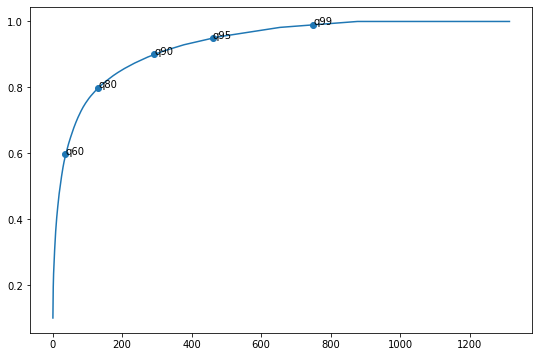

In [4]:
cum_dist_plot(data[1]["topics_dists"][0], quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(9,6))

In [5]:
def get_quantile(array, q):
    """
    Get number of elements that represent the 100q% of cumulative distribution of an array.
    """
    #cumulative distribution
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    
    #get quantile 
    cut = cum_dist.max()*q
    tail = cum_dist[cum_dist<=cut]
    if len(tail)>=1:
        quantile = np.argmax(tail)+1
    else:
        quantile = 1
    
    return quantile

In [6]:
q95_list = []
for slice in slices:
    topics = data[slice]["topics_dists"]
    topics.shape
    for i, topic in enumerate(topics):
        q95 = get_quantile(topic, 0.95)
        q95_list.append({"slice":slice, "topic":i, "vocabulary_size": len(topic),
                         "%q95":round(100*q95/len(topic),2)})

/home/dgarrido/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [7]:
df_q95 = pd.DataFrame(q95_list)
df_q95.head()

,slice,topic,vocabulary_size,%q95
0,1,0,1314,35.08
1,1,1,1314,29.15
2,1,2,1314,33.33
3,1,3,1314,4.95
4,1,4,1314,32.50


In [8]:
df_q95[["slice", "vocabulary_size", "%q95"]].groupby("slice").describe()

vocabulary_size                                                       \
                count    mean  std     min     25%     50%     75%     max   
slice                                                                        
1                 8.0  1314.0  0.0  1314.0  1314.0  1314.0  1314.0  1314.0   
2                 9.0  1418.0  0.0  1418.0  1418.0  1418.0  1418.0  1418.0   
3                 7.0  1497.0  0.0  1497.0  1497.0  1497.0  1497.0  1497.0   
4                 7.0  1551.0  0.0  1551.0  1551.0  1551.0  1551.0  1551.0   
5                 9.0  1457.0  0.0  1457.0  1457.0  1457.0  1457.0  1457.0   
6                 8.0  1507.0  0.0  1507.0  1507.0  1507.0  1507.0  1507.0   
7                 9.0  1514.0  0.0  1514.0  1514.0  1514.0  1514.0  1514.0   
8                 6.0  1498.0  0.0  1498.0  1498.0  1498.0  1498.0  1498.0   
9                 8.0  1496.0  0.0  1496.0  1496.0  1496.0  1496.0  1496.0   
10               10.0  1722.0  0.0  1722.0  1722.0  1722.0  1722.0  1722.0   
11               12.0  1573.0  0.0  1573.0  1573.0  1573.0  1573.0  1573.0   
12                9.0  1605.0  0.0  1605.0  1605.0  1605.0  1605.0  1605.0   
13                5.0  1686.0  0.0  1686.0  1686.0  1686.0  1686.0  1686.0   
14                8.0  1775.0  0.0  1775.0  1775.0  1775.0  1775.0  1775.0   
15                8.0  1738.0  0.0  1738.0  1738.0  1738.0  1738.0  1738.0   
16                5.0  1809.0  0.0  1809.0  1809.0  1809.0  1809.0  1809.0   
17                8.0  1772.0  0.0  1772.0  1772.0  1772.0  1772.0  1772.0   
18                9.0  1873.0  0.0  1873.0  1873.0  1873.0  1873.0  1873.0   
19               12.0  1926.0  0.0  1926.0  1926.0  1926.0  1926.0  1926.0   
20               10.0  1785.0  0.0  1785.0  1785.0  1785.0  1785.0  1785.0   
21               10.0  1824.0  0.0  1824.0  1824.0  1824.0  1824.0  1824.0   
22                8.0  1882.0  0.0  1882.0  1882.0  1882.0  1882.0  1882.0   
23               11.0  1896.0  0.0  1896.0  1896.0  1896.0  1896.0  1896.0   
24               11.0  1936.0  0.0  1936.0  1936.0  1936.0  1936.0  1936.0   

       %q95                                                                
      count       mean        std    min      25%     50%      75%    max  
slice                                                                      
1       8.0  17.712500  15.935330   1.67   2.5850  17.050  32.7075  35.08  
2       9.0  15.193333  14.819699   0.49   1.4100  10.790  32.6500  36.60  
3       7.0  20.868571  13.998906   2.07   8.3500  28.790  31.4600  35.60  
4       7.0  20.012857  15.348867   0.06   6.2850  25.470  33.0400  35.91  
5       9.0  15.633333  15.106569   0.07   1.7200   9.130  29.6500  37.41  
6       8.0  16.655000  17.256768   0.07   1.3975  12.770  31.5825  38.35  
7       9.0  14.575556  15.029527   0.13   1.9200   4.230  30.9800  34.02  
8       6.0  24.143333  12.463819   1.13  23.2175  25.570  31.8750  36.18  
9       8.0  17.697500  14.032322   0.07   4.5100  20.055  29.0125  35.09  
10     10.0  13.972000  13.780989   0.06   0.6525  10.570  28.3100  31.18  
11     12.0  11.958333  12.299065   0.25   0.9850   8.205  20.0300  31.53  
12      9.0  15.436667  14.650119   0.06   1.8700  10.280  29.2800  36.01  
13      5.0  26.358000   8.337135  13.52  24.2600  27.880  30.1900  35.94  
14      8.0  17.127500  13.291096   0.96   7.0850  17.580  26.8175  35.27  
15      8.0  17.441250  14.382926   0.23   1.8150  22.555  28.4100  34.29  
16      5.0  28.184000   4.096582  24.27  25.4300  26.370  30.8500  34.00  
17      8.0  17.522500  13.921642   0.28   5.0100  17.495  30.4325  35.16  
18      9.0  16.597778  13.588048   0.16   0.4300  21.620  27.7600  33.32  
19     12.0  11.356667  13.866397   0.05   0.7000   3.895  26.3500  33.07  
20     10.0  16.055000  11.811803   0.11   7.0425  15.460  26.3275  32.32  
21     10.0  13.695000  12.907239   0.05   1.1225  15.080  19.3000  33.55  
22      8.0  15.588750  13.240792   1.17   4.5300  13.895  24.5225  33.74  

In [160]:
df_q95["%q95"].describe()

count    207.000000
mean      16.200290
std       13.431725
min        0.050000
25%        1.595000
50%       15.080000
75%       29.325000
max       38.350000
Name: %q95, dtype: float64

In [10]:
df_q95["%q95"].quantile([0.6, 0.8, 0.9, 0.95, 0.99])

0.60    24.3300
0.80    30.8440
0.90    33.5540
0.95    35.1880
0.99    36.9384
Name: %q95, dtype: float64

Las conclusiones preliminares indican que en promedio con un 16% del vocabulario se puede capturar un 95% de la distribución acumulada de los tópicos. Además, para un 99% de los tópicos basta con un 37% del vocabulario para capturar el 95% de su distribución acumulada. Por tanto, una representación incompleta de los tópicos usando las palabras más probables que capturan el 95% de la cdf trae consigo una disminución importante en el tamaño del vocabulario, y por ende de los parámetros del EMD.

EL tamaño de los parámetros de EMD son (`fist_histogram(N), second_histogram(N), distance_matrix(NxN)`), luego la matriz de distancias es a lo más un 7.3%  de la matriz de distancia original. El poliedro del EMD es $Ax=b, x>=0$, con $A \in \mathbb{R}^{2N\times N^{2}}, b \in \mathbb{R}^{N}, x \in \mathbb{R}^{N^{2}}$.

Otra ventaja de reducir el tamaño de los tópicos es que el parámetro $b$ del poliedro es menos sparse y por ende es más estable numéricamente.

# 3. Distances

In [109]:
def wmd(embeddings, token2id1, token2id2, topic1, topic2, q=None):
    """
    Input
        embeddings: gensim.models.keyedvectors.FastTextKeyedVectors, 
            words embeddings.
        token2id1: dict[str->int], 
            mapping between tokens and ids from topic 1.
        token2id2: dict[str->int], 
            mapping between tokens and ids from topic 2.
        topic1: numpy.array[float64], 
            distribution from topic 1.
        topic2: numpy.array[float64], 
            distribution from topic 2.
        q: float64, optional, 
            quantile rate between [0-1], used to filter words with less probability in a topic.
            represents the top N most likely words in a topic, such that its cumulative distribution 
            adds up to q.
    Output
        distance: float64
            word movers distance between two topics.
    """
    
    if q:
        # get quantiles 
        q1 = get_quantile(topic_1, q) 
        q2 = get_quantile(topic_2, q)
        # get indexs of useful tokens
        index1 = pd.Series(topic_1).sort_values(ascending=False).index[0:q1]
        index2 = pd.Series(topic_2).sort_values(ascending=False).index[0:q2]
        # map id->token
        id2token1 = {v: k for k, v in token2id1.items()}
        id2token2 = {v: k for k, v in token2id2.items()}
        # get vocabulary from union of topic vocabularies
        vocabulary1 = set([id2token1[i] for i in index1])
        vocabulary2 = set([id2token2[i] for i in index2])
        vocabulary = vocabulary1.union(vocabulary2)
    else:
        # get vocabulary from union of topic vocabularies
        vocabulary1 = set(dict1.token2id.keys())
        vocabulary2 = set(dict2.token2id.keys())
        vocabulary = vocabulary1.union(vocabulary2)
    # topics distributions with padding
    first_histogram = np.array([topic1[token2id1[word]] if word in vocabulary1 else 0 for word in vocabulary])
    second_histogram = np.array([topic2[token2id2[word]] if word in vocabulary2 else 0 for word in vocabulary])    
    # compute euclidean distance matrix between vocabulary words
    vocabulary_array = np.array([embeddings[word] for word in vocabulary])
    distance_matrix = np.sqrt(np.sum((vocabulary_array[:, np.newaxis, :] - vocabulary_array[np.newaxis, :, :])**2, axis = -1))
    distance_matrix = distance_matrix.astype("float64")
    # compute Earth Mover Distances
    distance = emd(first_histogram, second_histogram, distance_matrix)
    return distance

In [11]:
logger.info("***Loading Embeddings***")

embeddings = load_facebook_vectors(args["embeddings"])

INFO:similarity-graph:***Loading Embeddings***
INFO:gensim.models._fasttext_bin:loading 855380 words for fastText model from fasttext-sbwc.bin
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 855380 unique words (50% of original 1710760) and increased the count of 855380 pre-existing words (50% of original 1710760)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 855380 items
INFO:gensim.models.word2vec:sample=0.0001 downsamples 582 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 1489095212 word corpus (106.9% of prior 1392829209)
INFO:gensim.models.fasttext:loaded (2855380, 300) weight matrix for fastText model from fasttext-sbwc.bin


In [93]:
token2id1 = data[1]["token2id"]
token2id2 = data[2]["token2id"]
topic_1 = data[1]["topics_dists"][0]
topic_2 = data[2]["topics_dists"][0]

In [112]:
%timeit distance = wmd(embeddings, token2id1, token2id2, topic1, topic2)

1min 9s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
%timeit distance = wmd(embeddings, token2id1, token2id2, topic1, topic2, q=0.95)

3.09 s ± 85.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
